In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
#needed for running on laptop~~~~~
from vedo import settings
settings.default_backend = 'vtk'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
# import tensorflow as tf
from scipy.spatial.transform import Rotation as R

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose3, Rot3, Point3
from pose_graph_utils import *
import tensorflow as tf
from tensorflow import  sin, cos, tan

import numpy as np
from matplotlib import pyplot as p
%load_ext autoreload
%autoreload 2

2025-05-04 17:54:57.406754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-04 17:54:59.324094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:/home/derm/ROS/devel/lib:/opt/ros/noetic/lib:/usr/local/lib
2025-05-04 17:54:59.324256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:/home/derm

# Draw frames from odometry constraints

In [179]:
#load relative poses from odometry file
# constraints = np.loadtxt("apartment/pose_data.csv", delimiter=',',skiprows=1)
constraints = np.loadtxt("pose_data.csv", delimiter=',',skiprows=1)

# print(constraints[:,0] == 1)
# print(constraints[:,:3])

odom_raw = constraints[constraints[:,0] == 0][:,1:]  # raw odometry constraints 
sr_raw = constraints[constraints[:,0] == 1][:,1:]    # sequential registration of keyframe constraints
lc_raw = constraints[constraints[:,0] == 2][:,1:]    # loop closure constraints
dc_raw = constraints[constraints[:,0] == 3][:,1:]    # dense constraint seeds (passed to loop closer node)

# odom_raw = sr_raw #DEBUG-- uncomment to draw SR traj ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# odom_raw = odom_raw[:(len(odom_raw)//2)]
print(len(odom_raw))
#convert to rotation matrix
odom = np.zeros([len(odom_raw),4,4])
odom[0] = np.eye(4)
for i in range(1,len(odom_raw)):
    odom[i] = np.eye(4)
    curr = np.eye(4)
    #Full 6DOF transform
#     curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_matrix() #scipy depreciated syntax :(
    curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_dcm() 
#     #Suppress Pitch and Roll
#     full_rot = R.from_quat(odom_raw[i,5:]).as_euler('xyz')
#     curr[:3,:3] = R.from_euler('xyz', [0,0,full_rot[2]]).as_matrix()

    curr[:3,-1] = odom_raw[i,2:5]
    #forward conga line (works)
    for j in range(i):
        odom[j] = curr @ odom[j]    

#bring back to map frame
OG = odom[0].copy()
for j in range(len(odom_raw)):
    odom[j] = np.linalg.pinv(OG) @ odom[j]
        
sr = np.zeros([len(sr_raw),4,4])
sr[0] = np.eye(4)
for i in range(len(sr_raw)):
    sr[i] = np.eye(4)
    curr = np.eye(4)
    #FULL DOF
#     curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_matrix()
    curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_dcm()
#     #Suppress Pitch and Roll
#     full_rot = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
#     curr[:3,:3] = R.from_euler('xyz', [0,0,full_rot[2]]).as_matrix()    
    curr[:3,-1] = sr_raw[i,2:5]
    for j in range(i+1):
        sr[j] = curr @ sr[j]

382


In [180]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]         
scale = 0.25
runlen = len(odom) - 1
# runlen = 75

for i in range(0,runlen):
    rotm = odom[i,:,:]
#     rotm = sr[i,:,:] #TEST
#     print(rotm)
    alph = 1-(i/runlen)
    
    #forward view direction (-z in NeRF c2w convention)
    # x
    headings = rotm[:3,:3] @ np.array([scale,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,scale,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    #draw line between odometry
    disp.append(Line(odom[i,:3,3], odom[i+1,:3,3], c = 'black', lw=2))
    
    #draw any potential loop closure constraints
    for j in range(len(lc_raw)):
        if lc_raw[j,0] == i:
            disp.append(Line(odom[i,:3,3], odom[int(lc_raw[j,1]),:3,3], c = 'red', lw=3, alpha = 0.7))
    

plt.show(disp, "dead reckoning from odometry constraints")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


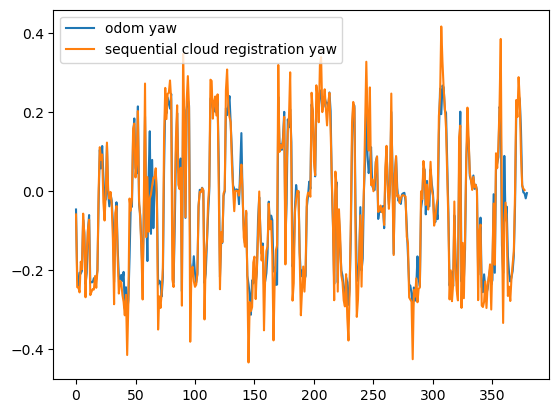

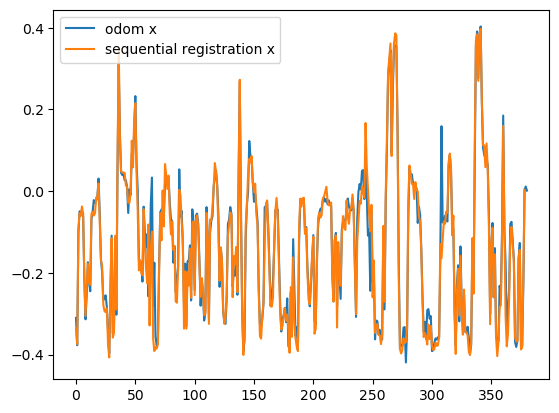

In [182]:
fig, ax = p.subplots()   
odom_euls = np.zeros([0,3])
for i in range(1,len(odom_raw)):
#     rotm = R.from_quat(odom_raw[i,5:]).as_matrix()
    rotm = R.from_quat(odom_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    odom_euls = np.append(odom_euls, rpy[None,:], axis = 0)

sr_euls = np.zeros([0,3])
for i in range(1,len(sr_raw)):
#     rotm = R.from_quat(sr_raw[i,5:]).as_matrix()
    rotm = R.from_quat(sr_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    sr_euls = np.append(sr_euls, rpy[None,:], axis = 0)

ax.plot(odom_euls[1:,2], label = 'odom yaw')
ax.plot(sr_euls[:,2], label = 'sequential cloud registration yaw')
ax.legend(loc='best')

fig, ax = p.subplots()
# print(odom_raw[:10,2:5], "\n \n", sr_raw[:10,2:5])
ax.plot(odom_raw[1:,2], label = 'odom x')
ax.plot(sr_raw[:,2], label = 'sequential registration x')
ax.legend(loc='best')

# Draw point clouds registered according to raw odometry and sequential keyframe registration

In [185]:
#load keyframe point clouds
idx = 20
idx2 = idx + 1
# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")
# print(odom_raw[idx,2:5], R.from_quat(odom_raw[idx,5:]).as_euler('xyz'))
print(odom_raw[idx])

#get row corresponding to correct odometry constraint
odom_idx = np.where(odom_raw[:,0] == idx)[0][0]
sr_idx = np.where(sr_raw[:,0] == idx)[0][0]
print(odom_idx, sr_idx)

[20.         21.          0.0308961  -0.0950914  -0.0298025   0.00023519
  0.00621082 -0.100045    0.994963  ]
20 19


In [186]:
plt = Plotter(N = 2, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp_odom=[]
disp_odom.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_odom.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
disp_sr=[]
disp_sr.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_sr.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))

# p2_p1f_odom = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_matrix()#works for odom output
# p2_p1f_sr = (pc2 - sr_raw[sr_idx,2:5]) @ R.from_quat(sr_raw[sr_idx,5:]).as_matrix()#works for odom output
p2_p1f_odom = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_dcm()#works for odom output
p2_p1f_sr = (pc2 - sr_raw[sr_idx,2:5]) @ R.from_quat(sr_raw[sr_idx,5:]).as_dcm()#works for odom output
disp_odom.append(Points(p2_p1f_odom, c = 'green', r = 3, alpha = 0.5))
disp_sr.append(Points(p2_p1f_sr, c = 'green', r = 3, alpha = 0.5))

plt.at(0).add(disp_odom, "odometry")              
plt.at(1).add(disp_sr, "loop closure between neighboring keyframes")              
plt.show()#"scan 1 (red), scan2 (blue), scan2 in s1 frame (green)" 

[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()
[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()
[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Look at loop closure canidates (from scan context)

In [187]:
lc_idx = 0
print(lc_raw[lc_idx,:])
idx = int((lc_raw[lc_idx,0]))
idx2 = int((lc_raw[lc_idx,1]))
print(idx, idx2)
print(R.from_quat(lc_raw[lc_idx,5:]).as_euler('xyz'))

# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
# p2_p1f_lc = (pc2 - lc_raw[lc_idx,2:5]) @ R.from_quat(lc_raw[lc_idx,5:]).as_matrix()
p2_p1f_lc = (pc2 - lc_raw[lc_idx,2:5]) @ R.from_quat(lc_raw[lc_idx,5:]).as_dcm()
disp.append(Points(p2_p1f_lc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "registering point clouds with scan context loop closure ") 

[14.         19.         -0.324127   -0.159724   -0.023972   -0.0123781
 -0.00348422 -0.575687    0.817569  ]
14 19
[-0.01623221 -0.01995033 -1.22684273]


[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


## Look at dense constraints

In [189]:
# print(dc_raw)
print(len(dc_raw))

359


In [190]:
dc_idx = 50
# print(dc_raw[dc_idx,:])
idx = int((dc_raw[dc_idx,0]))
idx2 = int((dc_raw[dc_idx,1]))
print(idx, idx2)
print(R.from_quat(dc_raw[dc_idx,5:]).as_euler('xyz'))

# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
p2_p1f_dc = (pc2 - dc_raw[dc_idx,2:5]) @ R.from_quat(dc_raw[dc_idx,5:]).as_dcm()
disp.append(Points(p2_p1f_dc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "registering point clouds with scan context loop closure ") 

22 65
[ 0.02257941  0.02035272 -2.92918064]


[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Optimize Sequential Keyframe trajectory + Loop Closure Constraints

In [127]:
OH = np.zeros([len(sr_raw)+len(lc_raw),8])
for i in range(len(sr_raw)):
    OH[i,:3] = sr_raw[i,2:5]
    OH[i,3:6] = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
    OH[i,6] = sr_raw[i,0] - 1
    OH[i,7] = sr_raw[i,1] - 1
for j in range(len(lc_raw)):
    OH[len(sr_raw)+j,:3] = lc_raw[j,2:5]
    OH[len(sr_raw)+j,3:6] = R.from_quat(lc_raw[j,5:]).as_euler('xyz')
    OH[len(sr_raw)+j,6] = lc_raw[j,0] - 1
    OH[len(sr_raw)+j,7] = lc_raw[j,1] - 1
    
    
odometry_history = OH
pred_stds_history = np.tile(np.array([[0.01, 0.01, 0.01, 1e-2, 1e-2, 1e-2]]), (len(odometry_history),1))

pred_stds_history[len(sr_raw):,:] *= 4 #10 #make loop closure constraints way higher covariance

pred_stds_history = np.append(pred_stds_history, odometry_history[:,-2:], axis = 1)
ij = odometry_history[:,-2:].astype(np.int32)

In [128]:
# Batch optimization
# Example constraint array: [x, y, z, roll, pitch, yaw, keyframe_idx1, keyframe_idx2]
constraints = odometry_history.copy()

# Initialize factor graph and values
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# Add a prior on the first keyframe to anchor the solution
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])  # Small uncertainty
# pose_prior = Pose3(Rot3.Identity(), Point3(0, 0, 0))
pose_prior = Pose3(Rot3.identity(), Point3(0, 0, 0))
graph.add(gtsam.PriorFactorPose3(0, pose_prior, prior_noise))

# Initialize first pose estimate
initial.insert(0, pose_prior)

# Add constraints and initialize other keyframes
for i, row in enumerate(constraints):
    x, y, z, roll, pitch, yaw, keyframe1, keyframe2 = row
    x *= -1
    y *= -1
    yaw *= -1  
#     #full 6 DOF
#     z *= -1
#     roll *= -1
#     pitch *= -1
#     PLANAR MOTION ONLY
    z *= 0
    roll *= 0
    pitch *= 0
    
    # Convert quaternion to rotation matrix
    rot = Rot3.Ypr(yaw, pitch, roll)  # YPR order (Yaw-Pitch-Roll)
    
    # Create relative Pose3 transformation
    relative_pose = Pose3(rot, Point3(x, y, z))

    # Define a noise model (adjust values based on confidence in constraints)
#     constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  
    constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([pred_stds_history[i,0], 
                                                         pred_stds_history[i,1], 
                                                         pred_stds_history[i,2], 
                                                         pred_stds_history[i,3], 
                                                         pred_stds_history[i,4], 
                                                         pred_stds_history[i,5]])  

    # Add BetweenFactorPose3 for relative transformation
    #had this
    graph.add(gtsam.BetweenFactorPose3(int(keyframe1), int(keyframe2), relative_pose, constraint_noise))

    # Initialize poses (assuming incremental movement)
    if not initial.exists(int(keyframe2)):
        prev_pose = initial.atPose3(int(keyframe1))
        initial.insert(int(keyframe2), prev_pose.compose(relative_pose))

# Optimize
params = gtsam.DoglegParams()
params.setMaxIterations(100)
params.setVerbosity("Termination")
optimizer = gtsam.DoglegOptimizer(graph, initial, params)
result = optimizer.optimize()

# Print results
# for i in range(len(constraints) + 1):
#     print(f"Pose {i}: {result.atPose3(i)}")


RuntimeError: Attempting to at the key "181", which does not exist in the Values.

In [91]:
from pose_graph_utils import *

#Plot results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []
disp = plot_results(disp, result, ij, draw_axis=True) #draw without ellipsoids
# disp = plot_results(disp, result, ij, marginals, draw_axis = True) #draws covarince ellipsoids
plt1.show(disp, "Factor Graph Optmized Poses")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Detect bad factors and run again

In [129]:
#Only works with batch optimized graph (iSAM2 doesn't retain internal state in the same way)
def mahalanobis_distance(error, covariance):
    """Compute the Mahalanobis distance."""
    return error.T @ np.linalg.inv(covariance) @ error

def detect_bad_loop_closures(graph, result, threshold=20.0):
    bad_factors = []
    for i in range(graph.size()):
        factor = graph.at(i) 
        if isinstance(factor, gtsam.BetweenFactorPose3):
            key1, key2 = factor.keys()

            # Compute expected relative pose based on current estimate
            expected_pose = result.atPose3(key1).between(result.atPose3(key2))
            measured_pose = factor.measured()
            
            # Compute the relative transformation error
            error = gtsam.Pose3.Logmap(measured_pose.inverse() * expected_pose)

            # Get covariance from noise model
            covariance = factor.noiseModel().covariance()

            # Compute Mahalanobis distance
            mdist = mahalanobis_distance(error, covariance)

            if mdist > threshold:
                print(f"Bad loop closure detected: {key1} -> {key2} (Mahalanobis dist: {mdist:.2f})")
                bad_factors.append(i)  # Store index of the bad factor
    return bad_factors

def optimize_slam(graph, initial_estimate, thresh = 20.):
    """Optimize the SLAM graph and remove bad loop closures based on Mahalanobis distance."""
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
    result = optimizer.optimize()

    # Detect bad loop closures
    bad_factors = detect_bad_loop_closures(graph, result, thresh)

    if bad_factors:
        # Remove bad constraints
        new_graph = gtsam.NonlinearFactorGraph()
        for i in range(graph.size()):
            if i not in bad_factors:
                new_graph.add(graph.at(i))

        # Re-optimize with cleaned graph
        optimizer = gtsam.LevenbergMarquardtOptimizer(new_graph, initial_estimate)
        result = optimizer.optimize()

    return result

# Initialize estimates for keyframe positions from initial graph convergence
initial_estimate = gtsam.Values()
current_pose = gtsam.Pose3()
for i in range(graph.size()):
    factor = graph.at(i)
    if isinstance(factor, gtsam.BetweenFactorPose3):
        key1, key2 = factor.keys()  # Get the keys

        if not initial_estimate.exists(key1):  # Insert key1 if not already present
            initial_estimate.insert(key1, current_pose)

        # Apply odometry to get next pose
        current_pose = current_pose.compose(factor.measured())

        if not initial_estimate.exists(key2):  # FIX: Check before inserting key2
            initial_estimate.insert(key2, current_pose)

thresh = 100 #too low and we lose connectivity in our odometry chain
result = optimize_slam(graph, initial_estimate, thresh)

Bad loop closure detected: 123 -> 124 (Mahalanobis dist: 158.28)
Bad loop closure detected: 124 -> 125 (Mahalanobis dist: 173.24)
Bad loop closure detected: 125 -> 126 (Mahalanobis dist: 184.22)
Bad loop closure detected: 126 -> 127 (Mahalanobis dist: 194.31)
Bad loop closure detected: 127 -> 128 (Mahalanobis dist: 220.43)
Bad loop closure detected: 128 -> 129 (Mahalanobis dist: 232.11)
Bad loop closure detected: 129 -> 130 (Mahalanobis dist: 249.91)
Bad loop closure detected: 130 -> 131 (Mahalanobis dist: 246.75)
Bad loop closure detected: 131 -> 132 (Mahalanobis dist: 248.23)
Bad loop closure detected: 132 -> 133 (Mahalanobis dist: 240.13)
Bad loop closure detected: 133 -> 134 (Mahalanobis dist: 232.00)
Bad loop closure detected: 134 -> 135 (Mahalanobis dist: 234.52)
Bad loop closure detected: 135 -> 136 (Mahalanobis dist: 199.81)
Bad loop closure detected: 136 -> 137 (Mahalanobis dist: 176.13)
Bad loop closure detected: 137 -> 138 (Mahalanobis dist: 156.68)
Bad loop closure detected

RuntimeError: An inference algorithm was called with inconsistent arguments.  The
factor graph, ordering, or variable index were inconsistent with each
other, or a full elimination routine was called with an ordering that
does not include all of the variables.

# Optimize with incramental graph via iSAM2

In [191]:
OH = np.zeros([len(sr_raw)+len(lc_raw),8])
# OH = np.zeros([len(sr_raw)+len(lc_raw)+len(odom_raw)-1,8])
for i in range(len(sr_raw)):
    OH[i,:3] = sr_raw[i,2:5]
    OH[i,3:6] = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
    OH[i,6] = sr_raw[i,0] - 1
    OH[i,7] = sr_raw[i,1] - 1
for j in range(len(lc_raw)-1):
#     OLD-- not matching up with true trajectory(?)
    OH[len(sr_raw)+j,:3] = lc_raw[j,2:5]
    OH[len(sr_raw)+j,3:6] = R.from_quat(lc_raw[j,5:]).as_euler('xyz')
    OH[len(sr_raw)+j,6] = lc_raw[j,0] - 1
    OH[len(sr_raw)+j,7] = lc_raw[j,1] - 1

odometry_history = OH
pred_stds_history = np.tile(np.array([[0.01, 0.01, 0.01, 1e-2, 1e-2, 1e-2]]), (len(odometry_history),1))

pred_stds_history[len(sr_raw):,:] *= 10 #make loop closure constraints way higher covariance

pred_stds_history = np.append(pred_stds_history, odometry_history[:,-2:], axis = 1)
ij = odometry_history[:,-2:].astype(np.int32)

In [198]:
# Example constraint array: [x, y, z, roll, pitch, yaw, keyframe_idx1, keyframe_idx2]
constraints = odometry_history.copy()

parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# Add a prior on the first keyframe to anchor the solution
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-3] * 6)  # Small uncertainty
pose_prior = Pose3(Rot3.identity(), Point3(0, 0, 0))
graph.add(gtsam.PriorFactorPose3(0, pose_prior, prior_noise))
initial.insert(0, pose_prior)  # Insert first keyframe

# Apply first update to initialize iSAM2
isam.update(graph, initial)
graph.resize(0)  # Clear graph after update
initial.clear()  # Clear values after inserting into iSAM2

for i, row in enumerate(constraints):
    x, y, z, roll, pitch, yaw, keyframe1, keyframe2 = row
    x *= -1
    y *= -1
    yaw *= -1  
    #full 6 DOF
    z *= -1
    roll *= -1
    pitch *= -1
# #     PLANAR MOTION ONLY
#     z *= 0
#     roll *= 0
#     pitch *= 0

    # Convert to Pose3 transformation
    rot = Rot3.Ypr(yaw, pitch, roll)  # YPR order (Yaw-Pitch-Roll)
    relative_pose = Pose3(rot, Point3(x, y, z))

    # Define a noise model
#     constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1] * 6) #uniform
    constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([pred_stds_history[i,0], 
                                                         pred_stds_history[i,1], 
                                                         pred_stds_history[i,2], 
                                                         pred_stds_history[i,3], 
                                                         pred_stds_history[i,4], 
                                                         pred_stds_history[i,5]])  
    # Add BetweenFactorPose3 to graph
    graph.add(gtsam.BetweenFactorPose3(int(keyframe1), int(keyframe2), relative_pose, constraint_noise))
    # Prepare new values for iSAM2
    new_values = gtsam.Values()
    if not isam.valueExists(int(keyframe2)):  # Check if keyframe2 is new
        prev_pose = isam.calculateEstimate().atPose3(int(keyframe1))  # Get latest estimate
        new_values.insert(int(keyframe2), prev_pose.compose(relative_pose))
    # Update iSAM2 incrementally
    isam.update(graph, new_values)    
    # Clear graph & values after update (iSAM2 retains internal state)
    graph.resize(0)
    new_values.clear()

result = isam.calculateEstimate()

In [199]:
#Plot (initial) results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []
disp = plot_results(disp, result, ij, draw_axis=True) #draw without ellipsoids
# disp = plot_results(disp, result, ij, marginals, draw_axis = True) #draws covarince ellipsoids
plt1.show(disp, "Factor Graph Optmized Poses")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Draw Keyframe Clouds on Optimized Trajectory 

In [197]:
plt1 = Plotter(N = 1, axes = 0, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []

for i in range(2,result.size(), 5):
    t = result.atPose3(i).matrix()
    pc = np.loadtxt("keyframe_" + str(i+1) + ".csv",delimiter=",")
    pc4 = np.append(pc, np.ones([len(pc),1]), axis = 1)
    pc_wf = (t @ pc4.T).T    
    disp.append(Points(pc_wf[:,:3], c = 'gray', r=3, alpha = 0.05))
    disp.append(Points(t[:3,-1][None,:], c = 'red', r = 10))

plt1.show(disp, "Drawing Optimized Map")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Filter out bad constraints